In [1]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# For clearer printing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For data handling
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
pd.options.mode.copy_on_write = True

In [4]:
data = yf.download('PLTR', start='2020-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


In [5]:
## Exponential Moving Average Formula Implementation

def ExponentialMovingAverage(data, lookback=50):
    data['ema'] = 0
    alpha = 2 / (lookback + 1)
    df = data[lookback:]
    
    # SMA for first 50
    ema_prev = data['Close'].iloc[:lookback].sum() / lookback

    for date, row in df.iterrows():
        ema_tdy = (row['Close'] - ema_prev) * alpha + ema_prev
        data.loc[date, 'ema'] = ema_tdy
        ema_prev = ema_tdy

    return data

ema_original_data = ExponentialMovingAverage(data.copy())

In [6]:
ema_original_data.tail()

,Open,High,Low,Close,Adj Close,Volume,ema
Date,,,,,,,
2024-12-24,81.089996,84.796997,81.000000,82.379997,82.379997,64983300,62.550290
2024-12-26,83.160004,83.489998,81.300003,82.139999,82.139999,60377100,63.318513
2024-12-27,81.419998,82.000000,77.930000,79.080002,79.080002,66975900,63.936611
2024-12-30,77.040001,79.239998,76.110001,77.180000,77.180000,60850900,64.455960
2024-12-31,77.580002,77.980003,73.650002,75.629997,75.629997,56267900,64.894157


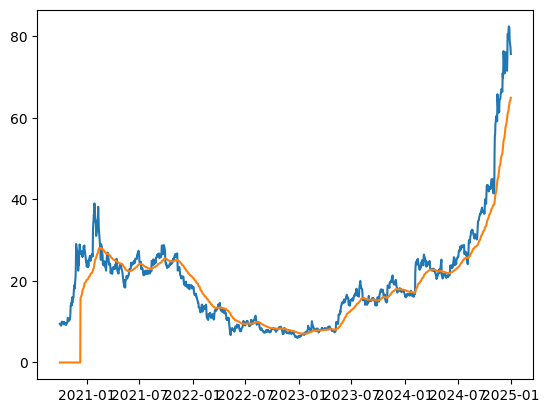

In [7]:
# Plot the predicted close prices with ema
plt.plot(ema_original_data['Close'])
plt.plot(ema_original_data['ema'])

In [8]:
# After noticing that the alpha value doesn't gaurantee a close approximation of the Close Prices,
# I decided to research how the alpha value can be dynamically changed for better performance. 
# This is an implementation of the ChandeMomentum Oscillator which greatly increased the overall performance of 
# the exponential moving average algorithm
def ChandeMomentumOscillator(data):
    diff = data['Close'].diff()
    gains = sum(diff[diff > 0]) / len(data)
    loss = abs(sum(diff[diff < 0]) / len(data))

    if gains + loss != 0:
        return 100 * ((gains - loss) / (gains + loss))

    return 0


ChandeMomentumOscillator(data)

10.253189413353873

In [9]:
# Combining EMA and Chande Oscillator into one function
def ExponentialMovingAverageChandeOscillator(data, lookback=50):
    data['ema'] = 0
    df = data[lookback:]
    
    # SMA for first 50
    ema_prev = data['Close'].iloc[:lookback].sum() / lookback

    for date, row in df.iterrows():
        alpha = ChandeMomentumOscillator(df.loc[date - pd.Timedelta(days=lookback):date])
        alpha = abs(alpha) / 100

        ema_tdy = (row['Close'] - ema_prev) * alpha + ema_prev
        data.loc[date, 'ema'] = ema_tdy
        ema_prev = ema_tdy

    return data

ema_momentum_oscillator_data = ExponentialMovingAverageChandeOscillator(data.copy())

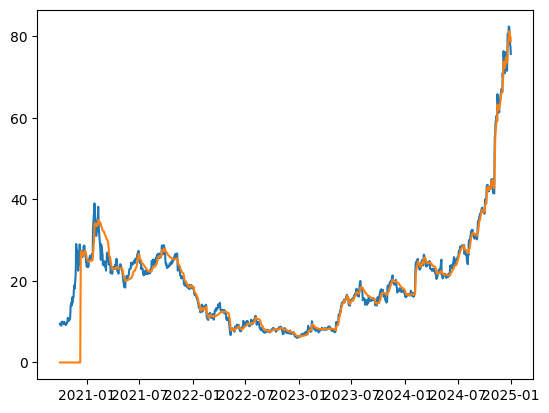

In [10]:
# Plotting both EMA and Close
plt.plot(ema_momentum_oscillator_data['Close'])
plt.plot(ema_momentum_oscillator_data['ema'])

In [11]:
# Implementation of the Sharpe Ratio metric
class SharpeRatio:
    def __init__(self, risk_free_rate, key, signal_type='Close>key'):
        self.risk_free_rate = risk_free_rate
        self.key = key
        self.signal_type = signal_type # For XGBoost, it uses positive returns as a signal and for EMA it uses greater ema values as a signal

    def __strategy_returns(self, data):
        if self.signal_type == 'Close>key':
            data['Signal'] = np.where(data['Close'] > data[self.key], 1, 0) 
        elif self.signal_type == 'key>0':
            data['Signal'] = np.where(data[self.key] > 0, 1, 0) 

        data['Position'] = data['Signal'].shift(1) 
        data['Daily Return'] = data['Close'].pct_change()
        data['Strategy Return'] = data['Position'] * data['Daily Return']
        
        return data['Strategy Return'].dropna()
        
    def __call__(self, data):
        returns = self.__strategy_returns(data)
        risk_free_daily = (1 + self.risk_free_rate) ** (1 / 252) - 1
        excess_returns = returns - risk_free_daily
        sharpe_ratio = excess_returns.mean() / excess_returns.std()
    
        return sharpe_ratio

In [12]:
# Implementation of EMA as a class to make it easier to use create a double EMA algorithm
class EMA:
    def __init__(self, oscillator):
        self.ema_prev = 0
        self.oscillator = oscillator

    def step(self, x, lookback_data):
        alpha = self.oscillator(lookback_data)
        alpha = abs(alpha) / 100
        
        ema_tdy = (x - self.ema_prev) * alpha + self.ema_prev
        self.ema_prev = ema_tdy
        return ema_tdy

    def set(self, x):
        self.ema_prev = x

In [13]:
# Run function that implements double EMA and Chande Oscillator
def run(data, lookback=60):
    data['ema1'] = 0
    data['ema2'] = 0
    
    df = data[lookback:]
    
    ema1 = EMA(oscillator=ChandeMomentumOscillator)
    ema2 = EMA(oscillator=ChandeMomentumOscillator)

    ema1.set(data['Close'].iloc[:lookback].sum() / lookback)

    for date, row in df.iterrows():
        lookback_data = df.loc[date - pd.Timedelta(days=lookback):date]
        x = row['Close']
        
        ema1_tdy = ema1.step(x, lookback_data)
        ema2_tdy = ema2.step(ema1_tdy, lookback_data)
        cema = round(2 * ema1_tdy - ema2_tdy, 3) # Formula for using double EMA
        # 2 * EMA - EMA(EMA)

        data.loc[date, 'ema1'] = ema1_tdy
        data.loc[date, 'ema2'] = cema
    
    return data

ema_double_oscillator_data = run(data.copy())

Text(0.5, 1.0, 'Performance for Palantir')

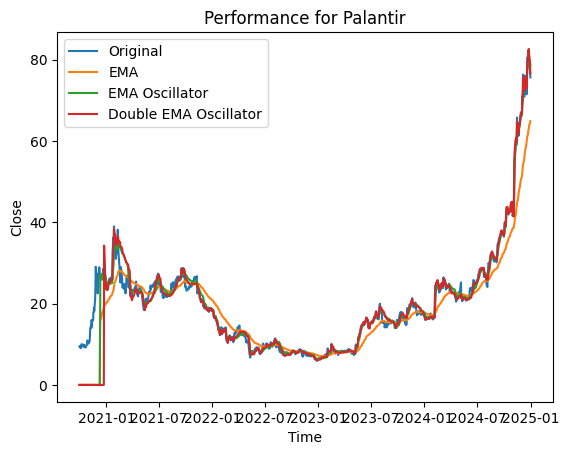

In [33]:
plt.plot(data['Close'], label='Original')
plt.plot(ema_original_data['ema'], label='EMA')
plt.plot(ema_momentum_oscillator_data['ema'], label='EMA Oscillator')
plt.plot(ema_double_oscillator_data['ema2'], label='Double EMA Oscillator')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Close")
plt.title("Performance for Palantir")

In [15]:
# Measuring the Sharpe Ratio for each implementation

# Sharpe Ratio for Double EMA + Oscillator
sharpe_2ema = SharpeRatio(0.00, 'ema2')
out_cema = sharpe_2ema(ema_double_oscillator_data.iloc[50:])

# Sharpe Ratio for EMA + Oscillator 
sharpe_oema = SharpeRatio(0.00, 'ema')
out_ema_m = sharpe_oema(ema_momentum_oscillator_data.iloc[50:])

# Sharpe Ratio for EMA
sharpe_ema_orig = SharpeRatio(0.00, 'ema')
out_ema_o = sharpe_ema_orig(ema_original_data.iloc[50:])

print(out_cema)
print(out_ema_m)
print(out_ema_o)

0.056535261575728905
0.05000819800038111
0.03355853726460802


In [16]:
# Formatting data for the XGB Regressor that predicts returns

tdata = data.copy()
tdata['ema1'] = ema_original_data['ema']
tdata['ema2'] = ema_momentum_oscillator_data['ema']
tdata['ema3'] = ema_double_oscillator_data['ema2']

tdata['returns'] = tdata['Close'].pct_change()
tdata.dropna(inplace=True)

X = tdata[['Close', 'ema1', 'ema2', 'ema3',]] 
y = tdata['returns']

In [17]:
# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Train the model
model.fit(X, y)

# Make predictions on the test set
predictions = model.predict(X)

Text(0.5, 1.0, 'Performance on PLTR')

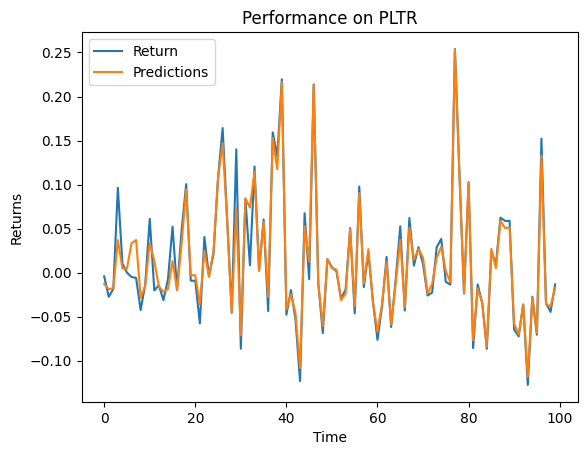

In [35]:
# Plotting Predictions of the Regressor
plt.plot(y.sort_index().values[:100], label='Return')
plt.plot(predictions[:100], label='Predictions')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Performance on PLTR")

In [19]:
# Adding Predictions to data frame
tdata['predictions'] = predictions

In [20]:
# Metrics for how closely the XGB Boost model follows the training data
rmse = mean_squared_error(y, predictions, squared=False)
r2 = r2_score(y, predictions)
print(rmse, r2)

0.010951416032390669 0.9410948958928506


In [21]:
# Sharpe Ratio
sharpe_ema_orig = SharpeRatio(0.00, 'predictions', 'key>0')
out_ema_o = sharpe_ema_orig(tdata)

In [22]:
print(out_ema_o)

0.08183996296308876


In [23]:
def constructXGB(d, d1, d2, d3):
    tdata = d.copy()
    tdata['ema1'] = d1['ema']
    tdata['ema2'] = d2['ema']
    tdata['ema3'] = d3['ema2']
    
    tdata['returns'] = tdata['Close'].pct_change()
    tdata.dropna(inplace=True)
    
    X = tdata[['Close', 'ema1', 'ema2', 'ema3',]] 
    y = tdata['returns']

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    
    model.fit(X, y)
    predictions = model.predict(X)
    tdata['predictions'] = predictions

    return tdata
    

In [31]:
def benchmark(ticker):
    d = yf.download(ticker, start='2020-01-01', end='2025-01-01', progress=False)
    lookback = 50
    
    ema_o_d = ExponentialMovingAverage(d.copy(), lookback)
    ema_m_o_d = ExponentialMovingAverageChandeOscillator(d.copy(), lookback)
    ema_d_o_d = run(d.copy(), lookback)

    sharpe_2ema = SharpeRatio(0.00, 'ema2')
    out_2ema = sharpe_2ema(ema_d_o_d.iloc[lookback:])
    
    # Sharpe Ratio for EMA + Oscillator 
    sharpe_oema = SharpeRatio(0.00, 'ema')
    out_ema_m = sharpe_oema(ema_m_o_d.iloc[lookback:])
    
    # Sharpe Ratio for EMA
    sharpe_ema_orig = SharpeRatio(0.00, 'ema')
    out_ema_o = sharpe_ema_orig(ema_o_d.iloc[lookback:])

    xgb_ema = constructXGB(d, ema_o_d, ema_m_o_d, ema_d_o_d)

    sharpe_ema_xgb = SharpeRatio(0.00, 'predictions', 'key>0')
    out_ema_xgb = sharpe_ema_xgb(xgb_ema)

    print(f"------------{ticker}------------")
    print(f"EMA Orig: {out_ema_o:.4f}, EMA Oscil: {out_ema_m:.4f}, EMA Doub: {out_2ema:.4f}, XGB: {out_ema_xgb:.4f}")  

In [32]:
top_10_tickers = [
    "AAPL",  # Apple 
    "MSFT",  # Microsoft 
    "NVDA",  # NVIDIA 
    "GOOGL", # Google
    "AMZN",  # Amazon
    "META",  # Meta
]

for ticker in top_10_tickers:
    benchmark(ticker)

------------AAPL------------
EMA Orig: 0.0610, EMA Oscil: 0.0518, EMA Doub: 0.0389, XGB: 0.0253
------------MSFT------------
EMA Orig: 0.0328, EMA Oscil: 0.0110, EMA Doub: 0.0253, XGB: -0.0002
------------NVDA------------
EMA Orig: 0.0807, EMA Oscil: 0.0938, EMA Doub: 0.0845, XGB: 0.0717
------------GOOGL------------
EMA Orig: 0.0382, EMA Oscil: 0.0111, EMA Doub: 0.0261, XGB: 0.0118
------------AMZN------------
EMA Orig: 0.0411, EMA Oscil: 0.0408, EMA Doub: 0.0425, XGB: 0.0354
------------META------------
EMA Orig: 0.0568, EMA Oscil: 0.0144, EMA Doub: 0.0318, XGB: 0.0219
